Customer Segment Questions:
1. Segment customers based on demographic data (age, gender, location)
2. Which demographics represent High Frequency Customers? 
3. Which demographics represent Low Frequency Customers?
4. HF vs. LF customers more likely to use a discount code?
5. Average Order Value from High Frequency Customers, AOV for Low Frequency Customers

Product Information Questions:
1. Which products have the highest conversion rate?
2. Top seasonality by total sales 
3. Total sales amount by marketing campaign
4. Total sales amount by month

Marketing Return on Investment:
1. Compare CPAs for Tik Tok vs. Email 
2. Which marketing campaigns had the highest conversions?

Begin by installing the following packages as followed:

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import random
import sqlite3
import sqlalchemy

You start exploring their customer base via customer demographics - a good place to start would be age, gender and location. 

We need to establish a connection to the database first, then store the SQL code as Python variables. This will be a repeating pattern in the marketing_analysis.ipynb file.

Same with visualizing the SQL code, we will need set variables in matplotlib library to execute. This will be another pattern you will see across the marketing_analysis.ipynb file. 

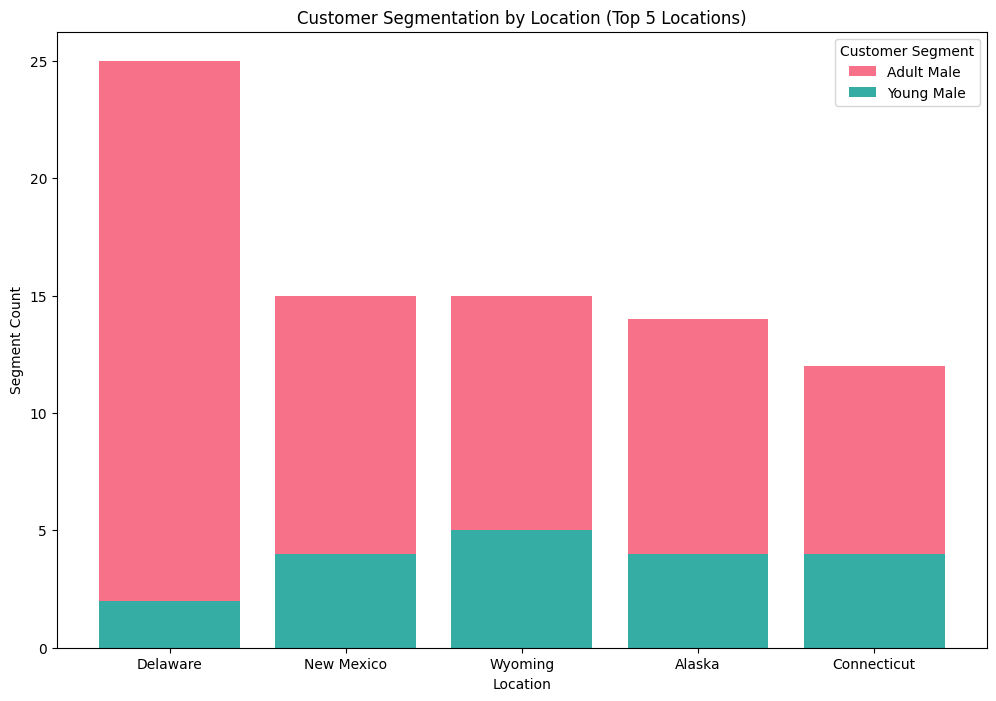

In [11]:
#Establish connection to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create customer_segment_1 variable with location, and setting Customer Segment parameters. We will group by location and order customer segments in descending order to see which customer segments are most frequent in this sales data. 
customer_segment_1 = '''
    SELECT
    Location,
    CASE
    WHEN Age < 30 AND Gender = 'Female' THEN 'Young Female'
    WHEN Age < 30 AND Gender = 'Male' THEN 'Young Male'
    WHEN Age >= 30 AND Gender = 'Female' THEN 'Adult Female'
    WHEN Age >= 30 AND Gender = 'Male' THEN 'Adult Male'
    ELSE 'Other'
    END AS Customer_Segment,
    COUNT(*) AS Segment_Count
    FROM merged_data
    GROUP BY Location, Customer_Segment
    ORDER BY Segment_Count DESC;
    '''

#Read customer_segment_1 variable to sql code
customer_segment_1 = pd.read_sql(customer_segment_1, conn)

#Create top locations variable based of off customer_segment_1 returns. We need to limit our visualizaiton to the Top 5 Locations. This is where we identify the 'Location' column in our variable, and use the 'value_counts' and '.nlargest(5)' commands. 
top_locations = customer_segment_1['Location'].value_counts().nlargest(5).index
customer_segment_1_top5 = customer_segment_1[customer_segment_1['Location'].isin(top_locations)]

# Plotting the bar graph with different colors
plt.figure(figsize=(12, 8))

# Use seaborn color palette for distinct colors
colors = sns.color_palette('husl', n_colors=len(customer_segment_1_top5['Customer_Segment'].unique()))

#Create list to iterate through top 5 customer segments, grouping by the SQL customer segment. 
#Let's use list comphrehension to identify each customer segment represented in the dataframe. In the 'plt.bar' we can define how each bar will represent a customer segment.
for i, (seg, group) in enumerate(customer_segment_1_top5.groupby('Customer_Segment')):
    plt.bar(
        group['Location'],
        group['Segment_Count'],
        label=seg,
        color=colors[i],
    )
#Create bar graph - the X-axis will be the grouped top 5 locations, the Y-axis will be the amount of grouped Segment Counts (Adult Male and Young Male)
plt.xlabel('Location')
plt.ylabel('Segment Count')
plt.title('Customer Segmentation by Location (Top 5 Locations)')
plt.legend(title='Customer Segment')
plt.show()

Interesting, so far it looks like our top customer segments between 2020-2023 were Adult Males in the states of Delaware, New Mexico, Wyoming, Alaska and Connecticut. 
Let's see if we can find our how often Adult Males are purchasing inventory by categorizing their spending patterns into High Frequency and Low Frequency segments. 

In [12]:
#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create customer_segment_2 variable to understand how often Adult Males are purchasing products; create High Frequency and Low Frequency Segments. 
#High Frequency = Weekly, Biweekly, Monthly
customer_segment_2 = '''
SELECT
    Location,
    CASE
        WHEN Age >= 30 AND Gender = 'Male' THEN 'Adult Male'
        ELSE 'Other'
    END AS Customer_Segment,
    COUNT(*) AS Segment_Count
FROM merged_data
WHERE Frequency_of_Purchases IN ("Weekly", "Biweekly", "Monthly") 
GROUP BY Location, Customer_Segment
ORDER BY Segment_Count DESC;
'''
customer_segment_2 = pd.read_sql(customer_segment_2, conn)

# Display the dataframe
print(customer_segment_2)
conn.close()

         Location Customer_Segment  Segment_Count
0          Nevada       Adult Male             11
1        Delaware       Adult Male             10
2            Iowa       Adult Male              9
3   Massachusetts       Adult Male              9
4           Idaho       Adult Male              8
..            ...              ...            ...
84   South Dakota            Other              1
85      Tennessee            Other              1
86           Utah            Other              1
87  West Virginia            Other              1
88        Wyoming            Other              1

[89 rows x 3 columns]


This code is a little more straightforward, so I've decided to forego a visualization here. It looks like our High Frequency Customer Segments are in Nevada, Delaware and Iowa. 

Let's analyze our Low Frequency Segements:

In [13]:
#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create customer_segment_3 for Low Frequency Segments
customer_segment_3 = '''
SELECT
    Location,
    CASE
        WHEN Age >= 30 AND Gender = 'Male' THEN 'Adult Male'
        ELSE 'Other'
    END AS Customer_Segment,
    COUNT(*) AS Segment_Count
FROM merged_data
WHERE Frequency_of_Purchases IN ("Quarterly","Annually") 
GROUP BY Location, Customer_Segment
ORDER BY Segment_Count DESC;
'''
customer_segment_3 = pd.read_sql(customer_segment_3, conn)

# Display the dataframe
print(customer_segment_3)
conn.close()

          Location Customer_Segment  Segment_Count
0     North Dakota       Adult Male             13
1        Minnesota       Adult Male             12
2   South Carolina       Adult Male             12
3         Missouri       Adult Male             11
4         Oklahoma       Adult Male             11
..             ...              ...            ...
87      New Jersey            Other              1
88      New Mexico            Other              1
89  North Carolina            Other              1
90            Ohio            Other              1
91    Rhode Island            Other              1

[92 rows x 3 columns]


It looks like their most frequent purchasers (High Frequency) are in the states of Nevada, Delaware, Iowa, Massachusetts and Idaho. Whereas your low frequency purchasers are in the states of Missouri, Oklahoma, South Carolina, Colorado and Florida. This is important to note when comparing to the first visualization which is a generalization of all historical customers.

Next, let's see if we can understand if High Frequency Customers (HFC) or Low Frequency Customers (LFC) are more likely to use a Discount Code. We will create a barplot displaying Frequency_of_Purchases and Usage_Counts as our axis, and group by all HFC and LFC.

We will also use last_purchase_month to understand when these customers are more likely to use Discount Codes.

In [14]:
#Customer Segment #4:
#Are High Frequency Customers or Low Frequency Customers more likely to use a discount code? In what month are they more likely to use a discount code?
#If High Frequency then Frequency_of_Purchases = weekly, biweekly, monthly;  if Low Frequency then Frequency_of_Purchases = quarterly, yearly;

#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create customer_segement_4 to group by Frequency_of_Purchses, Discount_Applied 
customer_segment_4 = '''
SELECT
    Frequency_of_Purchases,
    Discount_Applied,
    last_purchase_month,
    COUNT(*) AS Usage_Count
FROM
    merged_data
GROUP BY
    Frequency_of_Purchases, Discount_Applied, last_purchase_month
ORDER BY
    Usage_Count DESC;

'''

#Read segment to sql
customer_segment_4 = pd.read_sql(customer_segment_4, conn)

# Display the dataframe
print(customer_segment_4.head())
conn.close()

#Plot the bar graph
plt.figure(figsize=(14, 8))
#Use seaborn GnBu color palette for bar graph colors. Use the function 'hue' to display the different months where a customer segment would use a discount code.
sns.barplot(x='Frequency_of_Purchases', y='Usage_Count', hue='last_purchase_month', data=customer_segment_4, ci=None, palette="GnBu")
plt.title('Customers Most Likely to Use a Discount Code')
plt.show()

DatabaseError: Execution failed on sql '
SELECT
    Frequency_of_Purchases,
    Discount_Applied,
    last_purchase_month,
    COUNT(*) AS Usage_Count
FROM
    merged_data
GROUP BY
    Frequency_of_Purchases, Discount_Applied, last_purchase_month
ORDER BY
    Usage_Count DESC;

': no such column: last_purchase_month

Aggregating the Frequency Groups over the past 3 years of sales data, it looks like the Frequency_Segment group Bi-Weekly, Quarterly, and Weekly are the groups most likely to use a discount code during the Q2 and Q4 months. 

A common marketing KPI is knowing your company's Average Order Value (AOV). Typically this is a universal calculation that takes the total average of all items purchased (Purchase_Amount_USD). We will use that calculation here and group by our Frequency_of_Purchases segments to understand which customers are determined as "high value" vs. "low value."

In [15]:
#Customer Segment #5: Average Order Value from High Frequency Customers 
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create variable for customer_segment_5
customer_segment_5 = '''
SELECT Frequency_of_Purchases, AVG (Purchase_Amount_USD)
FROM merged_data
GROUP BY Frequency_of_Purchases;
'''

#Read customer_segment_5 variable to sql and display results
customer_segment_5 = pd.read_sql(customer_segment_5, conn)
print(customer_segment_5)
conn.close()

  Frequency_of_Purchases  AVG (Purchase_Amount_USD)
0               Annually                  58.662162
1              Bi-Weekly                  59.102564
2                Monthly                  59.034483
3              Quarterly                  61.222615
4                 Weekly                  59.271523


We want to ask this questions to see our highest value segment. It's often better to keep targeting groups with a higher order value versus those that do not. However, it looks like in this customer data all segments are relatively close in terms of average order value. 

  Item_Purchased     tiktok_campaign  COUNT (tiktok_conversion)
0        Sandals       we missed you                         55
1          Shoes             welcome                        127
2         Shorts      product launch                        119
3        Sweater  frequency purchase                        355
4         Blouse       cross product                        291
5           Coat      abandoned cart                         53


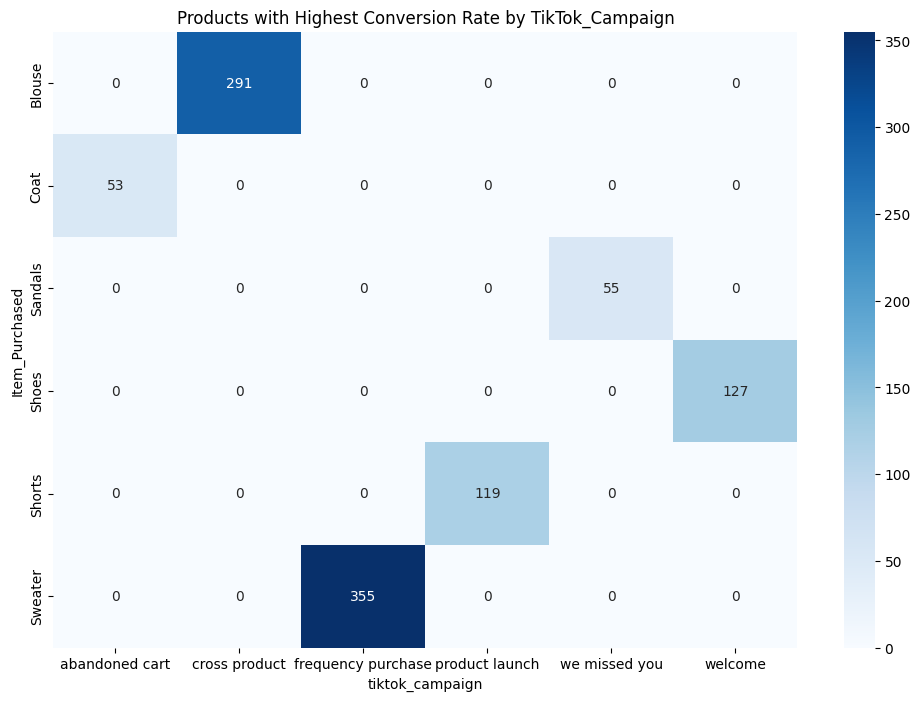

In [16]:
#Product Information #1:  Which products had the highest conversion rate by marketing campaign?

#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Lets set product information as a sub-variable of this section: 'product_information_1a' this will represent conversion rates for tiktok campaigns. 
product_information_1a = '''
SELECT Item_Purchased, tiktok_campaign, COUNT (tiktok_conversion)
FROM merged_data
GROUP BY tiktok_campaign
ORDER BY tiktok_conversion DESC;
'''

product_information_1a = pd.read_sql(product_information_1a, conn)
print(product_information_1a)

#Set a pivot table variable where the Index is the Item_Purchased column, and our columns:values are the Tiktok_Campaigns and their count of Conversions.
pivot_table = product_information_1a.pivot_table(index='Item_Purchased', columns='tiktok_campaign', values='COUNT (tiktok_conversion)', aggfunc='sum', fill_value=0)

# Plotting the heatmap with blues and greens colormap, using the pivot table variable as the dataset for the heatmap.
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g')
plt.title('Products with Highest Conversion Rate by TikTok_Campaign')
plt.show()

The different hues call out the highest conversion rates by product and by TikTok campaign. Here is looks like sweaters x Frequency Purchase campaign produced 355 conversions. Second to that would be Blouses x Cross Product campaigns and 3rd to that would be Shoes x Welcome campaign.

  Item_Purchased      email_campaign  COUNT (email_conversion)
0        Sweater             welcome                       354
1          Jeans       we missed you                        56
2          Jeans       cross product                       114
3         Blouse      abandoned cart                       235
4          Pants      product launch                        66
5           Coat  frequency purchase                       175


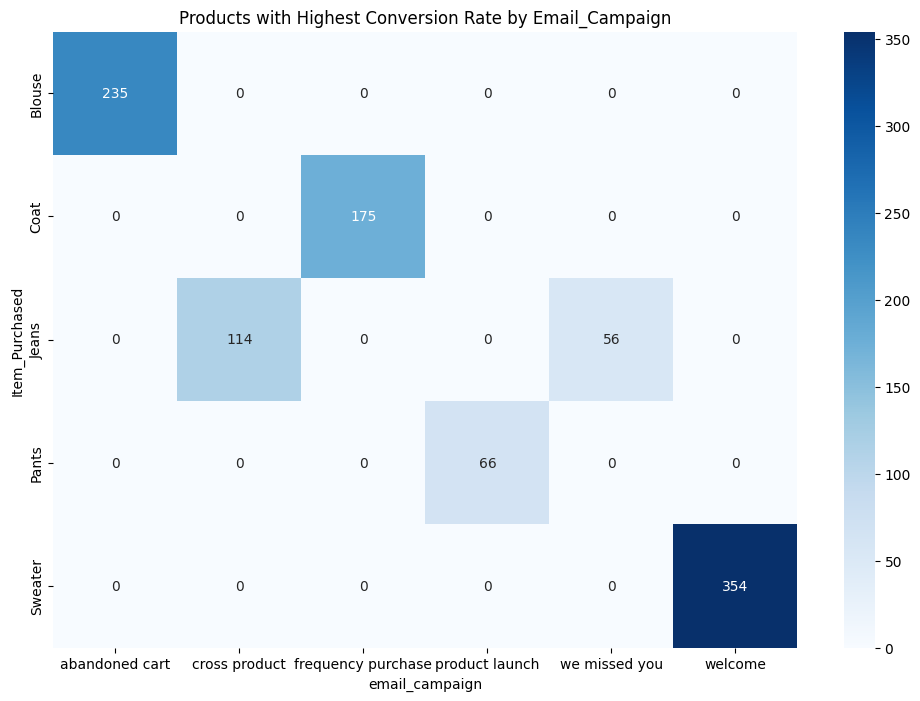

In [17]:
#Create variable for product_information_1b: this will represent conversion rates for email_campaigns. 
product_information_1b = '''
SELECT Item_Purchased, email_campaign, COUNT (email_conversion)
FROM merged_data
GROUP BY email_campaign
ORDER BY email_conversion DESC;
'''

product_information_1b = pd.read_sql(product_information_1b, conn)
print(product_information_1b)

pivot_table = product_information_1b.pivot_table(index='Item_Purchased', columns='email_campaign', values='COUNT (email_conversion)', aggfunc='sum', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g')
plt.title('Products with Highest Conversion Rate by Email_Campaign')
plt.show()

For email marketing efforts, it looks like Welcome emails x Sweaters produced 354 conversions, Blouses x Abandoned Cart produced 235 conversions, and coats produced 175 conversions from the Frequency Purchase campaign. 

At this stage, I might make a note that Blouses are a top product when the demographic points to Young Males and Adult Males. This could be a symptom of data cleanliness (ex: shirts are blouses but have been tagged as 'Blouses' on the website). Or perhaps the data is correct and Females do point to a large amount of conversions, but not larger than the Young Males or Adult Males segment.

Let's see if we can find out which season is most popular for this e-commerce company.

In [18]:
#Product Information #2 Total Sales Amount for seasonal clothing

#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Variable for product_information_2
product_information_2 = '''
SELECT Season, Total (Purchase_Amount_USD) DESC
FROM merged_data
GROUP BY Season;
'''

#Read variable to sql
product_information_2 = pd.read_sql(product_information_2, conn)
print(product_information_2)

   Season     DESC
0    Fall  15430.0
1  Spring  15220.0
2  Summer  14357.0
3  Winter  14646.0


It looks like the shoulder seasons of Spring and Fall have slightly higher total purchases over the past 3 years. Could be good information when evaluating the timing of marketing efforts. Let's see if we can dig into the Total Sales (different than conversions) by marketing campaign and by month. 

In [19]:
#Product Information #3: Total sales amount by marketing campaigns and month

#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create variable for product_information_3 that reflects conversions by marketing campaign and month
product_information_3 = '''
SELECT
    email_campaign,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    email_campaign, tiktok_campaign, first_purchase_month, last_purchase_month;
'''

#Read variable to sql
product_information_3 = pd.read_sql(product_information_3, conn)
print(product_information_3)

# Sort total sales with email campaigns (Total_Purchase_Amount) and group by the associated email campaign, sort by descending values
email_marketing_counts_sorted = product_information_3['Total_Purchase_Amount'].groupby(product_information_3['email_campaign']).sum().sort_values(ascending=False)

# Bar chart of email campaigns
plt.figure(figsize=(12, 8))
plt.bar(email_marketing_counts_sorted.index, email_marketing_counts_sorted, color='skyblue')
plt.xlabel("Email_Campaign")
plt.ylabel("SUM(Purchase_Amount_USD) AS Total_Purchase_Amount")
plt.title("Sales Total by Email Campaign")
plt.show()

DatabaseError: Execution failed on sql '
SELECT
    email_campaign,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    email_campaign, tiktok_campaign, first_purchase_month, last_purchase_month;
': no such column: first_purchase_month

It looks like the Welcome Email was the event that resulted in most sales.

In [20]:
#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create and resuse variable product_information_3
product_information_3 = '''
SELECT
    email_campaign, 
    last_purchase_month,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    email_campaign, tiktok_campaign, first_purchase_month, last_purchase_month;
'''

#Read variable to SQL
product_information_3 = pd.read_sql(product_information_3, conn)
print(product_information_3)

#Now, sort total sales with email campaigns (Total_Purchase_Am
# ount) and group by the associated email campaign, sort by descending values
email_marketing_counts_sorted = product_information_3['Total_Purchase_Amount'].groupby(product_information_3['last_purchase_month']).sum().sort_values(ascending=False)

# Bar chart of email campaigns
plt.figure(figsize=(12, 8))
plt.bar(email_marketing_counts_sorted.index, email_marketing_counts_sorted, color='skyblue')
plt.xlabel("last_purchase_month")
plt.ylabel("SUM(Purchase_Amount_USD) AS Total_Purchase_Amount")
plt.title("Email Sales by Month")
plt.show()

DatabaseError: Execution failed on sql '
SELECT
    email_campaign, 
    last_purchase_month,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    email_campaign, tiktok_campaign, first_purchase_month, last_purchase_month;
': no such column: last_purchase_month

It looks like May, July and October/November result in the most sales from email campaigns.

In [21]:
#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create and resuse variable product_information_3
product_information_3 = '''
SELECT
    tiktok_campaign,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    tiktok_campaign, last_purchase_month;
'''

#Read variable to SQL
product_information_3 = pd.read_sql(product_information_3, conn)
print(product_information_3)

# Sort total sales with tiktok campaigns (Total_Purchase_Amount) and group by the associated tiktok campaign, sort by descending values
tiktok_marketing_counts_sorted = product_information_3['Total_Purchase_Amount'].groupby(product_information_3['tiktok_campaign']).sum().sort_values(ascending=False)

# Bar chart of tiktok campaigns
plt.figure(figsize=(12, 8))
plt.bar(tiktok_marketing_counts_sorted.index, tiktok_marketing_counts_sorted, color='skyblue')
plt.xlabel("TikTok_Campaign")
plt.ylabel("SUM(Purchase_Amount_USD) AS Total_Purchase_Amount")
plt.title("Sales Total by Tiktok Campaign")
plt.show()

DatabaseError: Execution failed on sql '
SELECT
    tiktok_campaign,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    tiktok_campaign, last_purchase_month;
': no such column: last_purchase_month

It looks like the Frequency Purhase and Cross Product campaigns generate the most sales from TikTok. 

In [22]:
#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create and resuse variable product_information_3
product_information_3 = '''
SELECT
    tiktok_campaign, 
    last_purchase_month,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    tiktok_campaign,last_purchase_month;
'''

product_information_3 = pd.read_sql(product_information_3, conn)
print(product_information_3)

# Sort total sales with tiktok campaigns (Total_Purchase_Amount) and group by the associated tiktok campaign, sort by descending values
tiktok_marketing_counts_sorted = product_information_3['Total_Purchase_Amount'].groupby(product_information_3['last_purchase_month']).sum().sort_values(ascending=False)

# Bar chart of tiktok campaigns
plt.figure(figsize=(12, 8))
plt.bar(email_marketing_counts_sorted.index, email_marketing_counts_sorted, color='skyblue')
plt.xlabel("last_purchase_month")
plt.ylabel("SUM(Purchase_Amount_USD) AS Total_Purchase_Amount")
plt.title("TikTok Sales by Month")
plt.show()

DatabaseError: Execution failed on sql '
SELECT
    tiktok_campaign, 
    last_purchase_month,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    tiktok_campaign,last_purchase_month;
': no such column: last_purchase_month

Similar to email, TikTok generates the  most sales during the months of May, July, August and November. 

Let's see if we can identify which marketing campaigns results in a higher Cost Per Acquisition (CPA). This is another standard marketing KPI used to understand the cost benefit of marketing efforts.

In [23]:
#Marketing ROI #1: Compare CPAs for Tik Tok vs. Email 

#Connect to database 
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create marketing_roi_1 variable 
#Remove dollar sign and CAST to FLOAT
marketing_roi_1 = '''
SELECT
  AVG(CAST(REPLACE(tiktok_cpa, '$', '') AS FLOAT)) AS avg_tiktok_cpa,
  AVG(CAST(REPLACE(email_cpa, '$', '') AS FLOAT)) AS avg_email_cpa
FROM merged_data; 
'''

#Read variable to sql
marketing_roi_1 = pd.read_sql(marketing_roi_1, conn)
print(marketing_roi_1)

   avg_tiktok_cpa  avg_email_cpa
0         4.96912        5.11969


It looks like this e-commerce company had nearly equal CPAs across their two campaigns. In this instance, we want to focus on which campaigns had the highest sales or overall conversions. Let's see if we can understand that in our next block of code:

        email_campaign     tiktok_campaign  Conversion_Count
0              welcome       cross product                28
1              welcome  frequency purchase                28
2   frequency purchase  frequency purchase                19
3       abandoned cart       cross product                15
4       abandoned cart  frequency purchase                12
5        cross product  frequency purchase                10
6              welcome             welcome                10
7       abandoned cart      product launch                 9
8   frequency purchase       cross product                 9
9   frequency purchase      product launch                 9
10             welcome      product launch                 9
11      abandoned cart             welcome                 7
12             welcome      abandoned cart                 7
13       cross product       cross product                 6
14  frequency purchase      abandoned cart                 4
15      product launch  

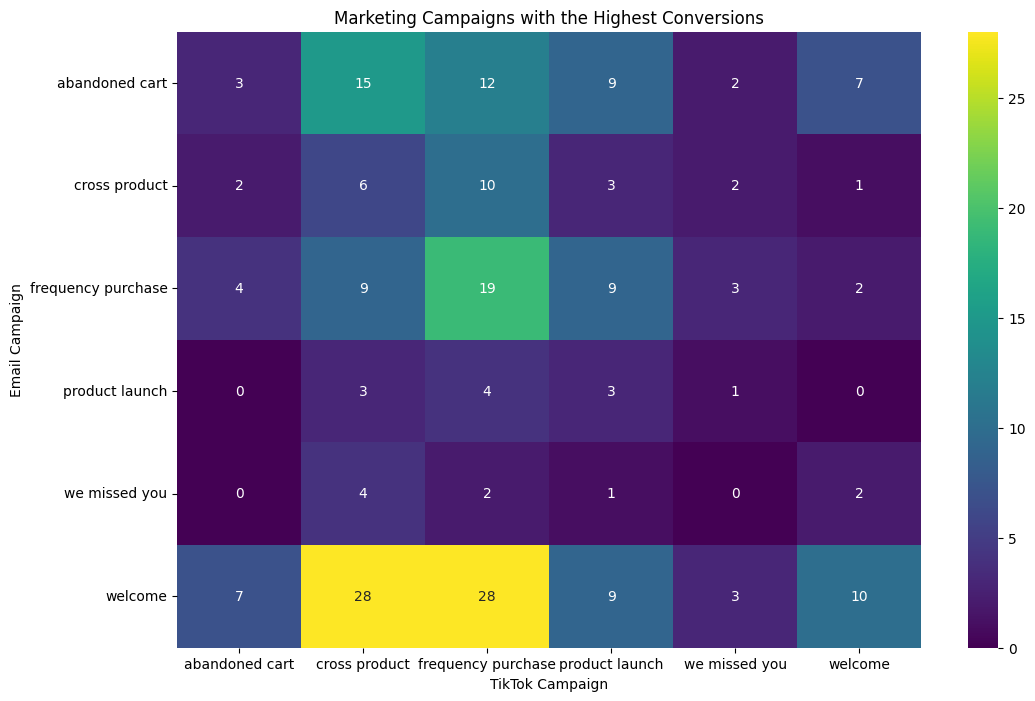

In [24]:
#Marketing ROI #2: Which marketing campaigns had the highest conversions?

#Connect to database
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

#Create marketing_roi_2 variable to evaluate if email or tiktok had the highest conversions
marketing_roi_2 = '''
SELECT
email_campaign,
tiktok_campaign,
COUNT(*) AS Conversion_Count
FROM
merged_data
WHERE
email_conversion = TRUE AND tiktok_conversion = TRUE
GROUP BY
email_campaign, tiktok_campaign
ORDER BY
Conversion_Count DESC;
'''

#Read variable to sql
marketing_roi_2 = pd.read_sql(marketing_roi_2, conn)
print(marketing_roi_2)

pivot_table = marketing_roi_2.pivot_table(
    values='Conversion_Count',
    index='email_campaign',
    columns='tiktok_campaign',
    aggfunc='sum',
    fill_value=0
)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='g')
plt.title('Marketing Campaigns with the Highest Conversions')
plt.xlabel('TikTok Campaign')
plt.ylabel('Email Campaign')
plt.show()

In yellow highlights the hotspots for conversions across both email and tiktok marketing campaigns. For example, the Welcome email campaign, the Cross Product TikTok campaign, and the Frequency Purchase TikTok campaign both resulted in 28 conversions. Something to consider when evaluating where marketing spend goes in the future.

Summary Findings

It looks like your highest sales come from Adult Males who live in the following states:
1. Delaware 
2. New Mexico 
3. Wyoming 
4. Alaska
5. Connecticut 

I would focus on putting marketing campaign spend towards Welcome campaigns for both TikTok and Email to incentivize new users with a discount code. I would incentivize returning users with Frequency Purchaser discount code. This is great for engaging and retaining existing high value customers. Line up these campaigns with months that have historical performed well with generating sales (May, June, July, August, October, November).

We could take this analysis a step further by analyzing sales data by state to understand customer segments by location, and analyzing website traffic to see how customer segments (Adult Male, Bi-Weekly buyer, etc.) aligns with purchasing behavior for this e-commerce company.  